## 1. Goal

To compute dependence of binary features (+ label) and numerical features

- Readout: Pearson Correlation Coefficient (Point-biserial)

- Dataset: the whole dataset (~200k URLs)


## 2. Feature extraction
- Remove string-type features (5 columns)
- Remove label (1 column) and store as a separate vector
- Split the remaining features into binary and numerical features


In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import pointbiserialr

In [2]:
# 0. Allow Google Colab to access to Google Drive (Mount)
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
# 1: read csv file
df = pd.read_csv('/content/drive/My Drive/00. BU BME/05. Spring 2024 (EC503)/Project/PhiUSIIL Phishing URL/PhiUSIIL_Phishing_URL_Dataset.csv')

# 2: Remove string features and label
non_string_df = df.select_dtypes(include=['int64', 'float64'])
labels = df['label']
# 3: Extract binary and non-binary (numerical) features
def extract_binary_and_non_binary_columns(data):
    binary_columns = []
    non_binary_columns = []
    for column in data.columns:
        if data[column].nunique() == 2 and set(data[column].unique()) == {0, 1}:
            binary_columns.append(column)
        else:
            non_binary_columns.append(column)
    return binary_columns, non_binary_columns

binary_columns, non_binary_columns = extract_binary_and_non_binary_columns(non_string_df)

# Print the binary columns
print("Binary Columns:")
print(binary_columns)

# Print the non-binary columns
print("\nNon-binary Columns:")
print(non_binary_columns)


Binary Columns:
['IsDomainIP', 'HasObfuscation', 'IsHTTPS', 'HasTitle', 'HasFavicon', 'Robots', 'IsResponsive', 'NoOfURLRedirect', 'NoOfSelfRedirect', 'HasDescription', 'HasExternalFormSubmit', 'HasSocialNet', 'HasSubmitButton', 'HasHiddenFields', 'HasPasswordField', 'Bank', 'Pay', 'Crypto', 'HasCopyrightInfo', 'label']

Non-binary Columns:
['URLLength', 'DomainLength', 'URLSimilarityIndex', 'CharContinuationRate', 'TLDLegitimateProb', 'URLCharProb', 'TLDLength', 'NoOfSubDomain', 'NoOfObfuscatedChar', 'ObfuscationRatio', 'NoOfLettersInURL', 'LetterRatioInURL', 'NoOfDegitsInURL', 'DegitRatioInURL', 'NoOfEqualsInURL', 'NoOfQMarkInURL', 'NoOfAmpersandInURL', 'NoOfOtherSpecialCharsInURL', 'SpacialCharRatioInURL', 'LineOfCode', 'LargestLineLength', 'DomainTitleMatchScore', 'URLTitleMatchScore', 'NoOfPopup', 'NoOfiFrame', 'NoOfImage', 'NoOfCSS', 'NoOfJS', 'NoOfSelfRef', 'NoOfEmptyRef', 'NoOfExternalRef']


In [4]:
# 4: Get values of binary or non-binary columns
binary_df = non_string_df[binary_columns] # 19 columns + 1 column (label)
#binary_df['label'] = labels # 1 column
non_binary_df = non_string_df[non_binary_columns] # 31 columns

binary_df, non_binary_df

(        IsDomainIP  HasObfuscation  IsHTTPS  HasTitle  HasFavicon  Robots  \
 0                0               0        1         1           0       1   
 1                0               0        1         1           1       1   
 2                0               0        1         1           0       1   
 3                0               0        1         1           0       1   
 4                0               0        1         1           0       1   
 ...            ...             ...      ...       ...         ...     ...   
 235790           0               0        1         1           1       1   
 235791           0               0        1         1           1       0   
 235792           0               0        1         1           1       1   
 235793           0               0        1         1           0       0   
 235794           0               0        1         1           0       1   
 
         IsResponsive  NoOfURLRedirect  NoOfSelfRedirect  HasD

## 3. Compute Absolute Pearson Correlation Coefficient between non-binary features
- Normalize all numerical feature values scaled 0 to 1
- Assume binary 0 or 1 to be numerical 0 or 1 to calculate correlation coefficient (Point-biserial)
- Sign of correlation coefficients does not matter -> take absolutes of them

In [5]:
# Define a function to normalize non-binary columns
def normalize_columns(df):
    return (df - df.min()) / (df.max() - df.min())

# Apply normalization to all columns
normalized_non_binary_df = normalize_columns(non_binary_df)

# Print the normalized DataFrame
print("Normalized Data:")
print(normalized_non_binary_df)

# Compute Pearson correlation coefficients
correlation_matrix = normalized_non_binary_df.corr(method='pearson')

# Compute absolute values of correlation coefficients
absolute_correlation_matrix = correlation_matrix.abs()

# Print correlation matrix
print("Absolute Pearson Correlation Coefficients between non-binary Columns:")
print(absolute_correlation_matrix)

Normalized Data:
        URLLength  DomainLength  URLSimilarityIndex  CharContinuationRate  \
0        0.002959      0.188679            1.000000              1.000000   
1        0.001644      0.113208            1.000000              0.666667   
2        0.002630      0.169811            1.000000              0.866667   
3        0.002137      0.141509            1.000000              1.000000   
4        0.003287      0.207547            1.000000              1.000000   
...           ...           ...                 ...                   ...   
235790   0.002630      0.169811            1.000000              1.000000   
235791   0.002465      0.160377            1.000000              0.785714   
235792   0.002794      0.179245            1.000000              1.000000   
235793   0.006903      0.405660            0.280456              0.465116   
235794   0.003287      0.207547            1.000000              1.000000   

        TLDLegitimateProb  URLCharProb  TLDLength  NoOfSub

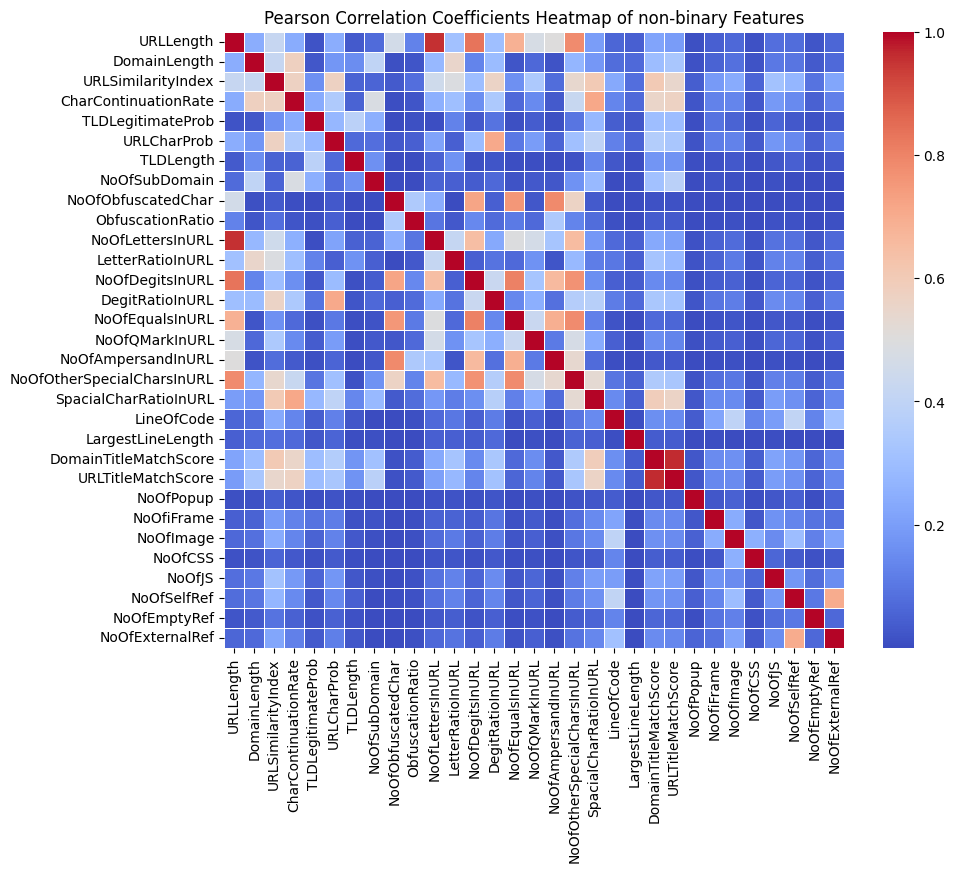

In [6]:
# Create heatmap
import seaborn as sns
plt.figure(figsize=(10, 8))
sns.heatmap(absolute_correlation_matrix, annot=False, cmap='coolwarm', linewidths=.5)
plt.title("Pearson Correlation Coefficients Heatmap of non-binary Features")
plt.show()

## 4. Compute Point-biserial correlation coefficients between binary and non-binary features
- Assume binary 0 or 1 to be numerical 0 or 1 to calculate correlation coefficient (Point-biserial)
- Sign of correlation coefficients does not matter -> take absolutes of them

In [7]:
from scipy.stats import pointbiserialr

# Prepare a DataFrame to store the results
results = pd.DataFrame(columns=['Binary Feature', 'Continuous Feature', 'Correlation Coefficient', 'P-Value'])

# Compute Point-biserial correlation for each binary-continuous pair
for binary_column in binary_columns:
    for continuous_column in non_binary_columns:
        coefficient, p_value = pointbiserialr(binary_df[binary_column], normalized_non_binary_df[continuous_column])
        new_row = pd.DataFrame({
            'Binary Feature': [binary_column],
            'Continuous Feature': [continuous_column],
            'Correlation Coefficient': [coefficient],
            'P-Value': [p_value]
        })
        results = pd.concat([results, new_row], ignore_index=True)

# Display the results
print(results)

# Pivot the results to create a matrix of correlation coefficients
PB_correlation_matrix = results.pivot(index='Binary Feature', columns='Continuous Feature', values='Correlation Coefficient')

# Compute absolute values of correlation coefficients
absolute_PB_correlation_matrix = correlation_matrix.abs()

# Print the correlation matrix
print(absolute_PB_correlation_matrix)

    Binary Feature    Continuous Feature  Correlation Coefficient  \
0       IsDomainIP             URLLength                 0.277272   
1       IsDomainIP          DomainLength                -0.041398   
2       IsDomainIP    URLSimilarityIndex                -0.121439   
3       IsDomainIP  CharContinuationRate                -0.101307   
4       IsDomainIP     TLDLegitimateProb                -0.053220   
..             ...                   ...                      ...   
615          label               NoOfCSS                 0.068109   
616          label                NoOfJS                 0.373500   
617          label           NoOfSelfRef                 0.316211   
618          label          NoOfEmptyRef                 0.109235   
619          label       NoOfExternalRef                 0.258627   

           P-Value  
0     0.000000e+00  
1     5.917858e-90  
2     0.000000e+00  
3     0.000000e+00  
4    1.834165e-147  
..             ...  
615  2.054700e-240  
616

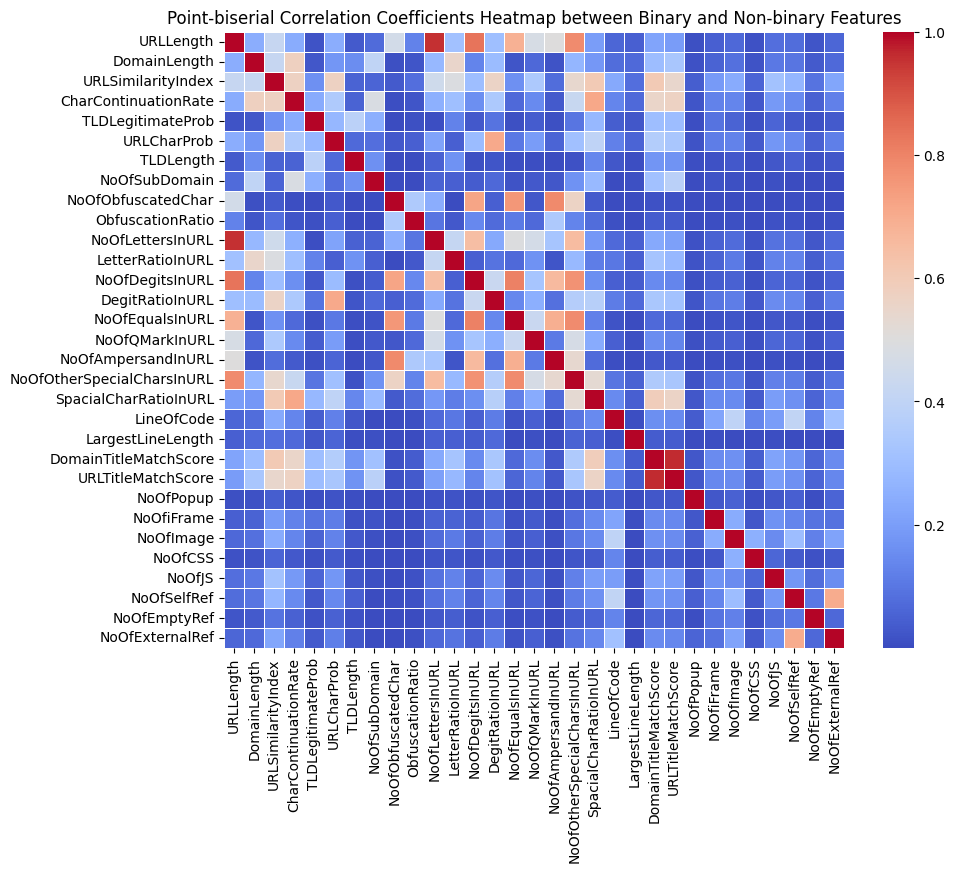

In [8]:
# Create heatmap
import seaborn as sns
plt.figure(figsize=(10, 8))
sns.heatmap(absolute_PB_correlation_matrix, annot=False, cmap='coolwarm', linewidths=.5)
plt.title("Point-biserial Correlation Coefficients Heatmap between Binary and Non-binary Features")
plt.show()

## 5. Compute phi coefficients between binary features
- Assume binary 0 or 1 to be numerical 0 or 1 to calculate correlation coefficient
- phi coefficients = Pearson between binary values
- Sign of correlation coefficients does not matter -> take absolutes of them

In [9]:
# Compute the Pearson correlation matrix
phi_coeff_matrix = binary_df.corr(method='pearson')

# Compute absolute values of correlation coefficients
absolute_phi_coeff_matrix = phi_coeff_matrix.abs()

# Display the Pearson correlation matrix
print(absolute_phi_coeff_matrix)

                       IsDomainIP  HasObfuscation   IsHTTPS  HasTitle  \
IsDomainIP               1.000000        0.001239  0.011741  0.004602   
HasObfuscation           0.001239        1.000000  0.014201  0.006150   
IsHTTPS                  0.011741        0.014201  1.000000  0.428830   
HasTitle                 0.004602        0.006150  0.428830  1.000000   
HasFavicon               0.030890        0.021323  0.343395  0.277612   
Robots                   0.028261        0.013184  0.288100  0.234625   
IsResponsive             0.006481        0.010224  0.480041  0.458961   
NoOfURLRedirect          0.023497        0.005859  0.004520  0.014514   
NoOfSelfRedirect         0.010231        0.008803  0.135950  0.065158   
HasDescription           0.021518        0.036486  0.431743  0.353031   
HasExternalFormSubmit    0.007988        0.006999  0.100211  0.085733   
HasSocialNet             0.046432        0.040298  0.479355  0.362788   
HasSubmitButton          0.011489        0.006663  

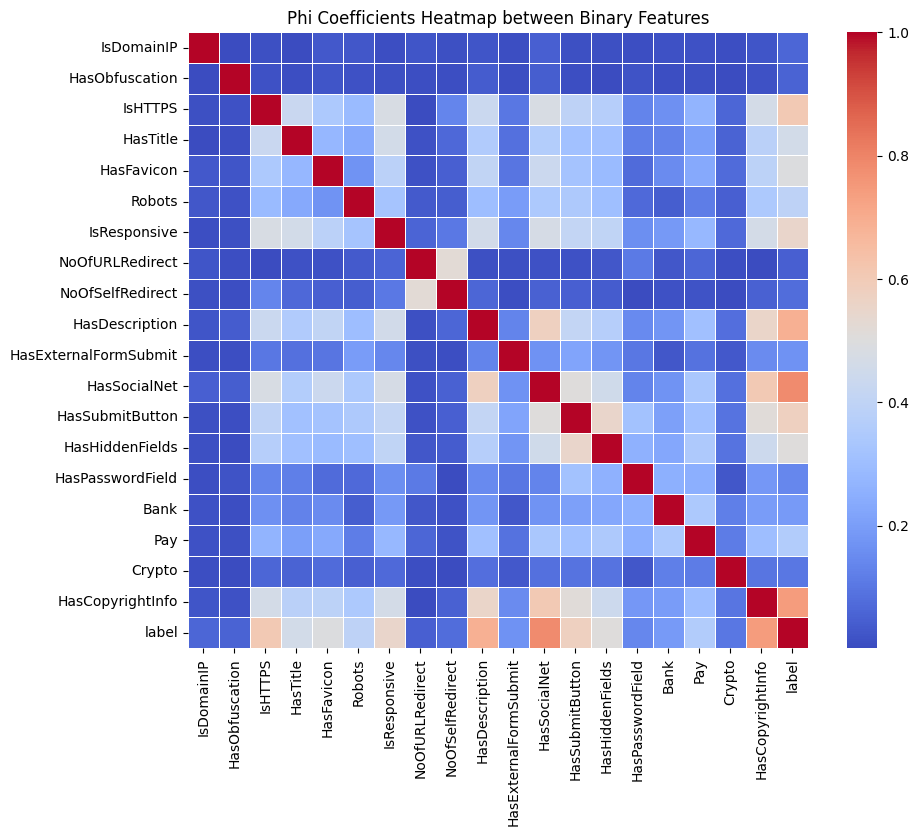

In [10]:
# Create heatmap
import seaborn as sns
plt.figure(figsize=(10, 8))
sns.heatmap(absolute_phi_coeff_matrix, annot=False, cmap='coolwarm', linewidths=.5)
plt.title("Phi Coefficients Heatmap between Binary Features")
plt.show()

## 6. Extract highly-correlated feature pairs
- Generate the full correlation matrix combining binary-binary, binary-continuous, and continuous-continuous matrices
- Find feature pairs with correlation coefficents higher than 0.5

In [8]:
continuous_columns = non_binary_columns

# Compute Pearson correlation matrix for binary features
binary_data = non_string_df[binary_columns]
binary_correlation = binary_data.corr(method='pearson')

# Compute Pearson correlation matrix for continuous features
continuous_data = non_string_df[continuous_columns]
continuous_correlation = continuous_data.corr(method='pearson')

# Create a placeholder for the full correlation matrix
all_features = continuous_columns + binary_columns
correlation_matrix = pd.DataFrame(index=all_features, columns=all_features)

# Fill the correlation matrix
# Binary-binary correlations
correlation_matrix.loc[binary_columns, binary_columns] = binary_correlation

# Continuous-continuous correlations
correlation_matrix.loc[continuous_columns, continuous_columns] = continuous_correlation

# Binary-continuous correlations (using Pearson for uniformity)
for binary_col in binary_columns:
    for continuous_col in continuous_columns:
        corr, _ = pointbiserialr(non_string_df[binary_col].dropna(), non_string_df[continuous_col].dropna())
        correlation_matrix.loc[binary_col, continuous_col] = corr
        correlation_matrix.loc[continuous_col, binary_col] = corr  # Symmetric

# Fill NaNs where appropriate (e.g., where no correlation was computed)
correlation_matrix.fillna(0, inplace=True)

# Convert everything to numeric as some entries might still be objects
correlation_matrix = correlation_matrix.astype(float)

# Compute absolute values of correlation coefficients
correlation_matrix = correlation_matrix.abs()

# Display the resulting matrix
print(correlation_matrix)

                            URLLength  DomainLength  URLSimilarityIndex  \
URLLength                    1.000000      0.243091            0.421104   
DomainLength                 0.243091      1.000000            0.420694   
URLSimilarityIndex           0.421104      0.420694            1.000000   
CharContinuationRate         0.241104      0.577425            0.572938   
TLDLegitimateProb            0.016656      0.027209            0.162042   
URLCharProb                  0.245215      0.178104            0.571622   
TLDLength                    0.033339      0.152669            0.053915   
NoOfSubDomain                0.071058      0.399157            0.058481   
NoOfObfuscatedChar           0.459094      0.011304            0.032257   
ObfuscationRatio             0.127472      0.021627            0.078989   
NoOfLettersInURL             0.956047      0.277602            0.449120   
LetterRatioInURL             0.312632      0.547854            0.491761   
NoOfDegitsInURL          

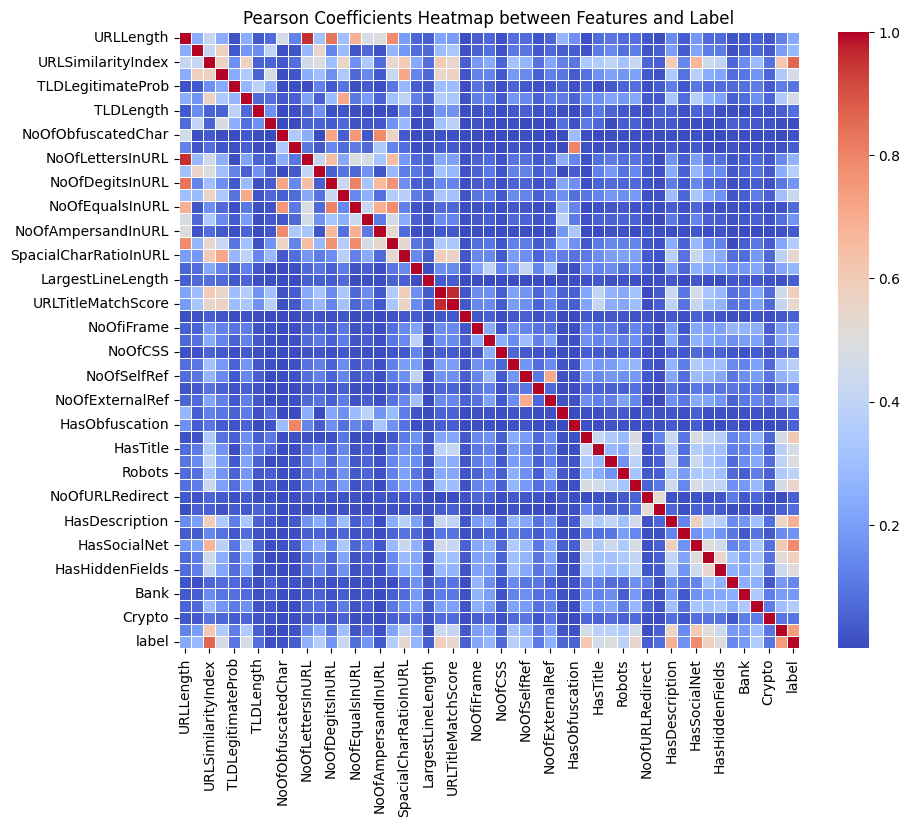

In [9]:
# Create heatmap
import seaborn as sns
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=False, cmap='coolwarm', linewidths=.5)
plt.title("Pearson Coefficients Heatmap between Features and Label")

# Save figure (should be called before 'plt.show')
from pathlib import Path

folder_path = Path('/content/drive/My Drive/00. BU BME/05. Spring 2024 (EC503)/Project/PhiUSIIL Phishing URL')
filename = 'Final_Exp2_Pearson heatmap.png'
full_path = folder_path / filename

plt.savefig(full_path, dpi=300)

plt.show()

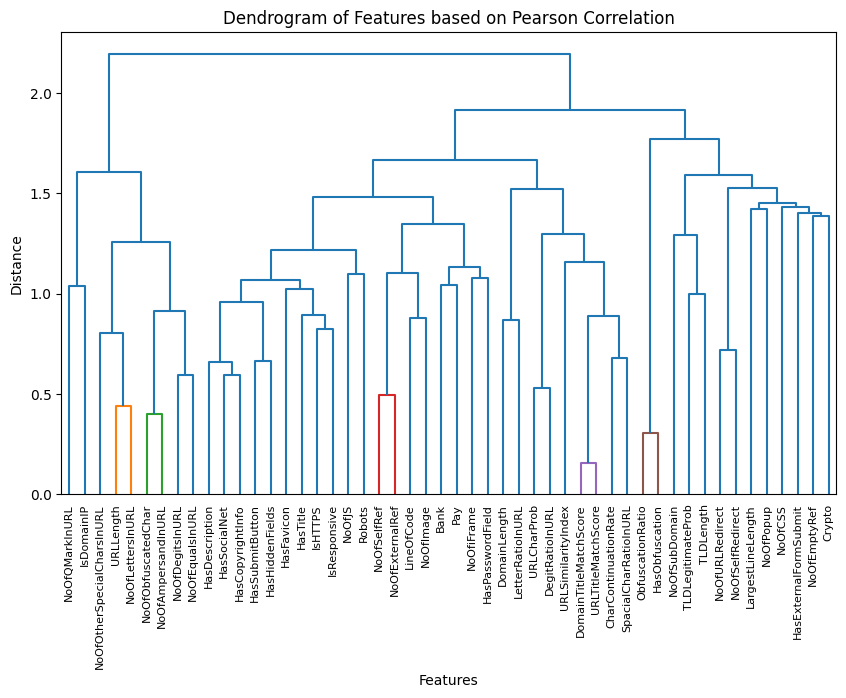

In [10]:
from scipy.cluster import hierarchy

# Remove label column and row in the correlation matrix
# Drop the column "FeatureName"
correlation_matrix.drop('label', axis=1, inplace=True)

# Drop the row "FeatureName"
correlation_matrix.drop('label', axis=0, inplace=True)

########## incorrect way of clustering - euclidean distance is not proper in correlation
# # Perform hierarchical clustering
# linkage = hierarchy.linkage(correlation_matrix, method='average', metric='euclidean')

# # Plot the dendrogram
# plt.figure(figsize=(10, 6))
# dn = hierarchy.dendrogram(linkage, labels=correlation_matrix.index, color_threshold=0.5)
# plt.title("Dendrogram of Features based on Pearson Correlation")
# plt.ylabel("Distance")
# plt.xlabel("Features")
# plt.xticks(rotation=90)
# plt.show()

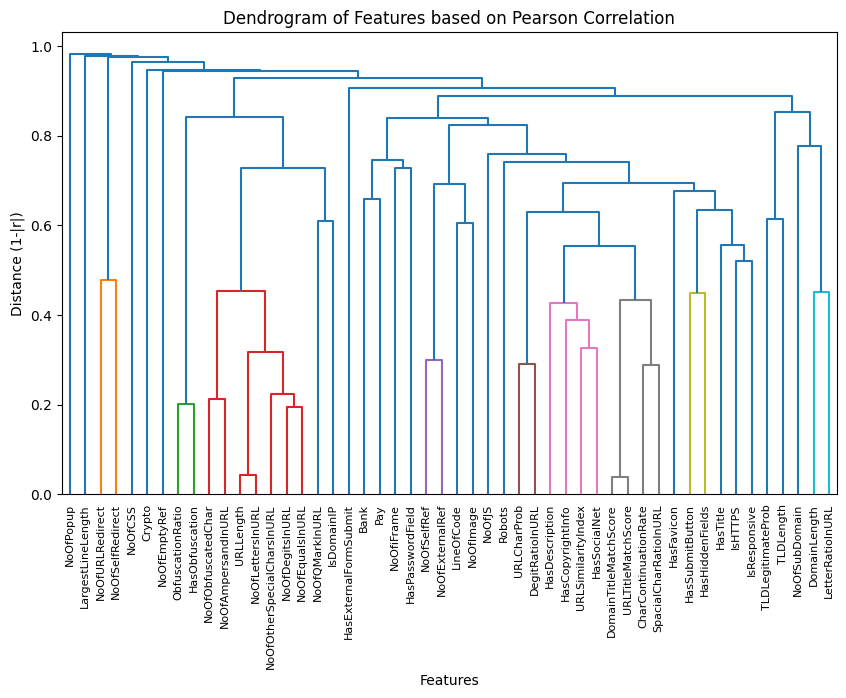

In [23]:
import numpy as np
from scipy.cluster import hierarchy
from scipy.spatial.distance import squareform
import matplotlib.pyplot as plt

distance_matrix = 1 - correlation_matrix

# Hierarchical clustering
# Convert the distance matrix to a condensed form since linkage function expects this format
condensed_distance_matrix = squareform(distance_matrix)
linkage_matrix = hierarchy.linkage(condensed_distance_matrix, method='average')

# Plot the dendrogram
plt.figure(figsize=(10, 6))
dn = hierarchy.dendrogram(linkage_matrix, labels=distance_matrix.index, color_threshold=0.5)
plt.title("Dendrogram of Features based on Pearson Correlation")
plt.ylabel("Distance (1-|r|)")
plt.xlabel("Features")
plt.xticks(rotation=90)
plt.show()

In [24]:
# Set the distance threshold for forming clusters
distance_threshold = 0.5

# Extract clusters based on the distance threshold
clusters = hierarchy.fcluster(linkage_matrix, t=distance_threshold, criterion='distance')

# Create a dictionary to store features for each cluster
cluster_features = {}
for i, cluster_id in enumerate(clusters):
    if cluster_id not in cluster_features:
        cluster_features[cluster_id] = []
    cluster_features[cluster_id].append(correlation_matrix.index[i])

# Create a table to enumerate groups containing features whose distance is less than 1.5
cluster_table = pd.DataFrame({'Cluster ID': list(cluster_features.keys()),
                              'Features': ['\n'.join(features) for features in cluster_features.values()]})

# Display the table
print(cluster_table)

    Cluster ID                                           Features
0            3  URLLength\nNoOfObfuscatedChar\nNoOfLettersInUR...
1           25                     DomainLength\nLetterRatioInURL
2           14  URLSimilarityIndex\nHasDescription\nHasSocialN...
3           15  CharContinuationRate\nSpacialCharRatioInURL\nD...
4           23                                  TLDLegitimateProb
5           13                       URLCharProb\nDegitRatioInURL
6           24                                          TLDLength
7           26                                      NoOfSubDomain
8            2                   ObfuscationRatio\nHasObfuscation
9            4                                     NoOfQMarkInURL
10          11                                         LineOfCode
11          31                                  LargestLineLength
12          32                                          NoOfPopup
13           8                                         NoOfiFrame
14        

In [25]:
# Function to count number of features in each cluster
def feature_count(features):
    return len(features.split("\n"))

cluster_df = cluster_table
# Apply function to count features
cluster_df['Feature Count'] = cluster_df['Features'].apply(feature_count)

# Create DataFrame for clusters with only one feature
single_feature_clusters = cluster_df[cluster_df['Feature Count'] == 1].copy()

# Drop clusters with only one feature from the original DataFrame
multi_feature_clusters = cluster_df[cluster_df['Feature Count'] > 1].copy()

# Print the DataFrame with single feature clusters
print("Single Feature Clusters:")
print(single_feature_clusters)

print("Multiple Feature Clusters:")
print(multi_feature_clusters)

Single Feature Clusters:
    Cluster ID               Features  Feature Count
4           23      TLDLegitimateProb              1
6           24              TLDLength              1
7           26          NoOfSubDomain              1
9            4         NoOfQMarkInURL              1
10          11             LineOfCode              1
11          31      LargestLineLength              1
12          32              NoOfPopup              1
13           8             NoOfiFrame              1
14          12              NoOfImage              1
15          30                NoOfCSS              1
16          22                 NoOfJS              1
18          28           NoOfEmptyRef              1
19           5             IsDomainIP              1
20          17                IsHTTPS              1
21          19               HasTitle              1
22          20             HasFavicon              1
23          21                 Robots              1
24          18       

In [31]:
# Split the 'Features' string on newlines and explode into separate rows
multi_feature_clusters_expanded = multi_feature_clusters.assign(Features=multi_feature_clusters['Features'].str.split('\n')).explode('Features').reset_index(drop=True)

# Rename the columns for clarity
multi_feature_clusters_expanded.columns = ['Cluster ID', 'Feature', 'Feature Count']

# Display the newly formatted DataFrame
print("Expanded Multi-Feature Clusters:")
print(multi_feature_clusters_expanded)

# Group by 'Cluster ID' and aggregate the 'Feature' into a list
cluster_features_dict = multi_feature_clusters_expanded.groupby('Cluster ID')['Feature'].apply(list).to_dict()

# Display the dictionary
print("Cluster Features Dictionary:")
print(cluster_features_dict)

# Convert the dictionary to a DataFrame
multi_feature_clusters_df = pd.DataFrame(cluster_features_dict.items(), columns=['Cluster', 'Features'])

multi_feature_clusters_df.to_csv('/content/drive/My Drive/00. BU BME/05. Spring 2024 (EC503)/Project/PhiUSIIL Phishing URL/multi_cluster_features.csv', index=False)

Expanded Multi-Feature Clusters:
    Cluster ID                     Feature  Feature Count
0            3                   URLLength              7
1            3          NoOfObfuscatedChar              7
2            3            NoOfLettersInURL              7
3            3             NoOfDegitsInURL              7
4            3             NoOfEqualsInURL              7
5            3          NoOfAmpersandInURL              7
6            3  NoOfOtherSpecialCharsInURL              7
7           25                DomainLength              2
8           25            LetterRatioInURL              2
9           14          URLSimilarityIndex              4
10          14              HasDescription              4
11          14                HasSocialNet              4
12          14            HasCopyrightInfo              4
13          15        CharContinuationRate              4
14          15       SpacialCharRatioInURL              4
15          15       DomainTitleMatchSc

In [33]:
# Ensure single features are also in an expanded format similar to multi-feature clusters
single_feature_clusters_expanded = single_feature_clusters.assign(Features=single_feature_clusters['Features'].str.split('\n')).explode('Features').reset_index(drop=True)
single_feature_clusters_expanded.columns = ['Cluster ID', 'Feature', 'Feature Count']

# Combine single and multiple feature clusters
combined_clusters = pd.concat([multi_feature_clusters_expanded, single_feature_clusters_expanded], ignore_index=True)

# Group by 'Cluster ID' and aggregate the 'Feature' into a list
combined_features_dict = combined_clusters.groupby('Cluster ID')['Feature'].apply(list).to_dict()

# Display the combined dictionary
print("Combined Cluster Features Dictionary:")
print(combined_features_dict)

# Convert dictionary back to DataFrame
combined_clusters_df = pd.DataFrame(list(combined_features_dict.items()), columns=['Cluster ID', 'Features'])

combined_clusters_df.to_csv('/content/drive/My Drive/00. BU BME/05. Spring 2024 (EC503)/Project/PhiUSIIL Phishing URL/cluster_features.csv', index=False)

Combined Cluster Features Dictionary:
{1: ['NoOfURLRedirect', 'NoOfSelfRedirect'], 2: ['ObfuscationRatio', 'HasObfuscation'], 3: ['URLLength', 'NoOfObfuscatedChar', 'NoOfLettersInURL', 'NoOfDegitsInURL', 'NoOfEqualsInURL', 'NoOfAmpersandInURL', 'NoOfOtherSpecialCharsInURL'], 4: ['NoOfQMarkInURL'], 5: ['IsDomainIP'], 6: ['Bank'], 7: ['Pay'], 8: ['NoOfiFrame'], 9: ['HasPasswordField'], 10: ['NoOfSelfRef', 'NoOfExternalRef'], 11: ['LineOfCode'], 12: ['NoOfImage'], 13: ['URLCharProb', 'DegitRatioInURL'], 14: ['URLSimilarityIndex', 'HasDescription', 'HasSocialNet', 'HasCopyrightInfo'], 15: ['CharContinuationRate', 'SpacialCharRatioInURL', 'DomainTitleMatchScore', 'URLTitleMatchScore'], 16: ['HasSubmitButton', 'HasHiddenFields'], 17: ['IsHTTPS'], 18: ['IsResponsive'], 19: ['HasTitle'], 20: ['HasFavicon'], 21: ['Robots'], 22: ['NoOfJS'], 23: ['TLDLegitimateProb'], 24: ['TLDLength'], 25: ['DomainLength', 'LetterRatioInURL'], 26: ['NoOfSubDomain'], 27: ['HasExternalFormSubmit'], 28: ['NoOfEmpty

# Conclusion

- **Branches and Leaves**: Each leaf (at the bottom) represents one of the features from dataset. The height of the branches indicates the distance or dissimilarity between features or groups of features. Features that are more similar in terms of their Pearson correlation coefficients are joined by branches that are closer to the horizontal axis at the bottom, while those that are less similar are joined by higher branches.

- **Color Coding**: The dendrogram uses different colors to represent distinct clusters based on a distance threshold. Here, it seems that you've used a threshold distance of 1.5 (as suggested by the code), which is why branches below this line are color-coded, signifying they are part of the same cluster. Above this threshold, branches are colored grey, indicating that they are not grouped into the same cluster at this level of similarity.

- **Clustering**: The dendrogram shows the hierarchical nature of feature similarity — starting with individual features, then merging them into small clusters, and these, in turn, are merged into larger clusters. Features or clusters that merge at the lower heights (closer to 0) are more similar to each other than those that merge at higher heights.

- **Insight into Features**: By examining which features are grouped together, you can infer which features might have similar properties or effects. For instance, features that are part of the same cluster could potentially be used interchangeably in models, or one might be omitted to reduce dimensionality without losing much information.

The specific names and groupings of the features are crucial to providing more detailed insights. Given the colors and the heights at which the branches merge, you can identify which features are closely related and how all the features are structured in terms of their correlation to each other.

# conclusion

The image you’ve provided is a cluster map that combines a heatmap with dendrograms on both axes. This visualization is based on the Pearson correlation coefficients between features in your dataset.

Here's how to interpret the cluster map:

- **Heatmap**: The main section shows the pairwise correlation coefficients between features. Darker blue colors indicate low correlation, while red shades represent high correlation. The color intensity thus reflects the strength and direction of the linear relationship between features.

- **Dendrograms**: On the top and the side of the heatmap, you have the dendrograms which illustrate how the features cluster together. Similar to the previous dendrogram explanation, features that are more closely related are linked at lower heights (distance), while those with less similarity are linked at higher distances.

- **Clusters of Features**: Looking at where the branches connect in the dendrograms allows you to identify clusters of features. Features that are grouped together in the dendrogram on the left side have similar correlation profiles with all other features. Similarly, the dendrogram on the top groups features that have a similar pattern of correlation with the rest.

- **Correlation Values**: On the heatmap, a strong positive correlation (close to 1) is indicated by red squares, a strong negative correlation (close to -1) would appear in blue, and no correlation (around 0) would appear in white. The presence of red squares along the diagonal is expected since it represents the correlation of features with themselves, which is always 1.

- **Insight into Data Structure**: This visual representation helps identify which features are redundant due to high correlation, which could be candidates for removal or combination to simplify models and reduce multicollinearity.

- **Analyzing Specific Clusters**: For a detailed analysis, you'd look at specific clusters where high correlations are visible. For example, if you see a cluster of features with many red squares, those features are highly positively correlated with each other. They might be measuring related aspects of your data or behaving similarly under the same conditions.

The cluster map is a valuable tool for understanding the structure of your dataset and guiding data preprocessing steps like feature selection or dimensionality reduction.

